In [165]:
import numpy as np
import pandas as pd

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [311]:
df = pd.read_excel('Data/All Data combined.xlsx')
df

,Unnamed: 0,number of trials,number of parameters,type of function,accuracy [calc. max/ actual max],time per trial [s],type_of_opt,assigned_class
0,0.0,16,2,Trig,0.732417,0.009824,CmaEs,0
1,1.0,13,2,Trig,0.983980,0.008316,CmaEs,0
2,2.0,10,2,Trig,0.638160,0.007854,CmaEs,0
3,3.0,18,2,Trig,0.952784,0.009196,CmaEs,0
4,4.0,11,2,Trig,0.284646,0.007938,CmaEs,0
...,...,...,...,...,...,...,...,...
1345,NaN,8,2,Trig,0.034904,0.007662,CMA-ES,5
1346,NaN,8,2,Trig,0.091423,0.010617,CMA-ES,5
1347,NaN,14,2,Trig,0.015566,0.019561,CMA-ES,5
1348,NaN,9,2,Trig,0.076210,0.011982,CMA-ES,5


In [312]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['type_of_opt'], axis=1)

In [313]:
df = df[df['accuracy [calc. max/ actual max]'] < 1.05]  

In [314]:
x = df[['number of trials','number of parameters','accuracy [calc. max/ actual max]', 'time per trial [s]']].values

In [315]:
#df['type_of_opt'].replace('CmaEs', 1,inplace=True)
#df['type_of_opt'].replace('Random', 2,inplace=True)
#df['type_of_opt'].replace('TPE', 3,inplace=True)
y = df['assigned_class']

In [316]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.30)

In [317]:
x_train = StandardScaler().fit(x_train).transform(x_train)
x_test = StandardScaler().fit(x_test).transform(x_test)
x_train = MinMaxScaler().fit(x_train).transform(x_train)
x_test = MinMaxScaler().fit(x_test).transform(x_test)

In [318]:
y_train = np.asarray(y_train)

In [319]:
x_train.shape

(933, 4)

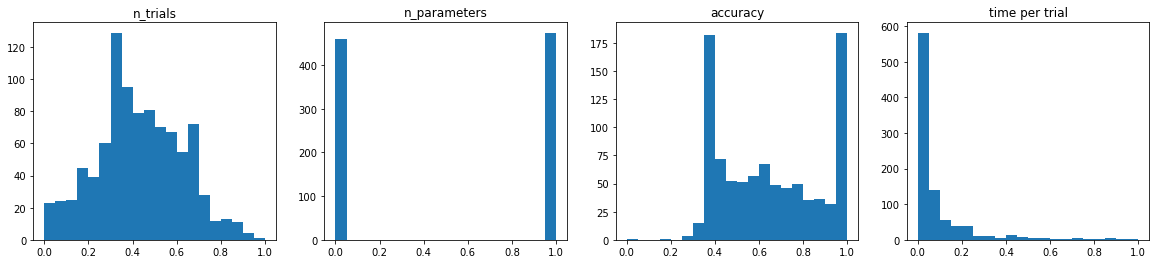

In [339]:
fig, ax = plt.subplots(figsize=(20,4), ncols = 4)
ax[0].hist(x_train[:,0], bins = 20)
ax[0].set_title('n_trials')
ax[1].hist(x_train[:,1], bins = 20)
ax[1].set_title('n_parameters')
ax[2].hist(x_train[:,2], bins = 20)
ax[2].set_title('accuracy')
ax[3].hist(x_train[:,3], bins = 20)
ax[3].set_title('time per trial')
plt.show()


## Using a Decision Tree Classifier 

In [324]:
def func(x,y):
    estimator = DecisionTreeClassifier(max_depth= int(np.round(x)))
    clf = BaggingClassifier(base_estimator=estimator, n_estimators= int(np.round(y)))
    clf = clf.fit(x_train, y_train)
    yhat = clf.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    
    return  acc

from bayes_opt import BayesianOptimization

xmin = 1
xmax = 50
ymin = 1
ymax = 50

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=3)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.6409   |  22.78    |  36.65    |
|  2        |  0.6309   |  11.59    |  22.77    |
|  3        |  0.6633   |  7.202    |  40.77    |
|  4        |  0.6509   |  38.72    |  48.54    |
|  5        |  0.6608   |  31.14    |  34.84    |
|  6        |  0.6858   |  6.717    |  41.64    |
|  7        |  0.601    |  3.414    |  16.43    |
|  8        |  0.6484   |  21.01    |  32.58    |
|  9        |  0.6559   |  11.89    |  16.46    |
|  10       |  0.6234   |  12.29    |  19.8     |
|  11       |  0.6459   |  5.027    |  23.11    |
|  12       |  0.6085   |  36.93    |  8.95     |
|  13       |  0.6359   |  4.637    |  49.1     |
|  14       |  0.6384   |  37.33    |  15.18    |
|  15       |  0.6334   |  4.239    |  21.38    |
|  16       |  0.6459   |  27.44    |  21.24    |
|  17       |  0.6209   |  26.85    |  19.73    |
|  18       |  0.6434   |  15.81    |  31.75    |


In [325]:
estimator = DecisionTreeClassifier(max_depth=int(np.round(found_x)))
clf = BaggingClassifier(base_estimator=estimator, n_estimators= int(np.round(found_y)))
clf = clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [326]:
acc

0.655860349127182

In [327]:
x = np.array([1,0,0.4,0]).reshape(1,-1)
x

array([[1. , 0. , 0.4, 0. ]])

In [328]:
clf.predict(x)

array([1])

## Using a Random Forest Classifier 

In [329]:
def func(x,y):
    rfr = RandomForestClassifier(max_depth = int(np.round(x)), n_estimators = int(np.round(y)), max_features = 4)
    rfr = rfr.fit(x_train, y_train.flatten())
    yhat = rfr.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    return  acc

from bayes_opt import BayesianOptimization

xmin = 1
xmax = 100
ymin = 1
ymax = 100

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=4)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.6509   |  66.29    |  88.38    |
|  2        |  0.6534   |  70.73    |  10.22    |
|  3        |  0.6209   |  75.2     |  30.0     |
|  4        |  0.6035   |  86.63    |  3.527    |
|  5        |  0.6434   |  17.59    |  87.02    |
|  6        |  0.596    |  2.558    |  44.02    |
|  7        |  0.6434   |  95.92    |  85.44    |
|  8        |  0.6334   |  97.37    |  92.55    |
|  9        |  0.6284   |  29.28    |  13.81    |
|  10       |  0.6209   |  82.16    |  5.028    |
|  11       |  0.6608   |  9.654    |  59.4     |
|  12       |  0.6334   |  17.27    |  47.67    |
|  13       |  0.6484   |  49.99    |  87.8     |
|  14       |  0.6484   |  32.78    |  94.38    |
|  15       |  0.6334   |  48.52    |  64.54    |
|  16       |  0.6633   |  95.83    |  59.12    |
|  17       |  0.6434   |  24.42    |  51.86    |
|  18       |  0.6185   |  85.84    |  25.66    |


In [330]:
rfr = RandomForestClassifier(max_depth = int(np.round(found_x)), n_estimators = int(np.round(found_y)), max_features = 4)
rfr = rfr.fit(x_train, y_train.flatten())
yhat = rfr.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [331]:
MSE

1.0773067331670823

In [285]:
acc

0.6234413965087282

## Using a Gradient Boosting Classifier 

In [340]:
def func(x,y):
    gbr = GradientBoostingClassifier(n_estimators = int(np.round(x)), max_depth = int(np.round(y)), learning_rate = 0.1)
    gbr = gbr.fit(x_train, y_train.flatten())
    yhat = gbr.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    
    return  acc

from bayes_opt import BayesianOptimization

xmin = 1
xmax = 50
ymin = 1
ymax = 50

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=3)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.5461   |  43.54    |  38.76    |
|  2        |  0.6135   |  36.1     |  7.907    |
|  3        |  0.6035   |  27.7     |  14.3     |
|  4        |  0.5411   |  2.98     |  19.92    |
|  5        |  0.5586   |  11.01    |  18.39    |
|  6        |  0.5486   |  17.5     |  28.94    |
|  7        |  0.5436   |  30.86    |  40.26    |
|  8        |  0.5461   |  25.1     |  28.37    |
|  9        |  0.5711   |  36.97    |  16.41    |
|  10       |  0.5411   |  22.97    |  20.89    |
|  11       |  0.5935   |  15.54    |  12.23    |
|  12       |  0.5461   |  36.57    |  29.02    |
|  13       |  0.5461   |  37.7     |  39.65    |
|  14       |  0.5436   |  12.36    |  45.51    |
|  15       |  0.5461   |  24.86    |  32.98    |
|  16       |  0.5786   |  10.84    |  8.138    |
|  17       |  0.5362   |  1.773    |  27.95    |
|  18       |  0.601    |  28.59    |  8.707    |


In [341]:
gbr = GradientBoostingClassifier(n_estimators = int(np.round(found_x)), max_depth = int(np.round(found_y)), learning_rate = 0.1)
gbr = gbr.fit(x_train, y_train.flatten())
yhat = gbr.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [342]:
MSE

1.3216957605985038

In [343]:
acc

0.6408977556109726